<a href="https://colab.research.google.com/github/Bushra1423/MedDiagnose2/blob/main/Chest_X_Ray_Classification_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp /kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions to secure the file

In [ ]:
!kaggle datasets download -d pritpal2873/chest-x-ray-dataset-4-categories -p /content/

Dataset URL: https://www.kaggle.com/datasets/pritpal2873/chest-x-ray-dataset-4-categories
License(s): apache-2.0


In [ ]:
import zipfile
import os

zip_path = "/content/chest-x-ray-dataset-4-categories.zip"  # Update if needed
extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
import os
import pandas as pd

# Update base path to the extracted dataset directory
base_path = "/content/dataset/Chest X_Ray Dataset"
image_paths = []
categories = []

categories_list = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

for category in categories_list:
    category_path = os.path.join(base_path, category)

    if os.path.exists(category_path):

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image_paths.append(image_path)
            categories.append(category)

df = pd.DataFrame({'image_path': image_paths, 'category': categories})


In [ ]:
df.head()

,image_path,category
0,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19
1,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19
2,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19
3,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19
4,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19


In [ ]:
df.tail()

,image_path,category
7127,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS
7128,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS
7129,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS
7130,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS
7131,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS


In [ ]:
df.shape

(7132, 2)

In [ ]:
df.columns

Index(['image_path', 'category'], dtype='object')

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

,0
image_path,0
category,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7132 entries, 0 to 7131
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  7132 non-null   object
 1   category    7132 non-null   object
dtypes: object(2)
memory usage: 111.6+ KB


In [ ]:
df['category'].unique()

array(['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'], dtype=object)

In [ ]:
df['category'].value_counts()

,count
category,
PNEUMONIA,4273
NORMAL,1583
TURBERCULOSIS,700
COVID19,576


<ipython-input-13-63c71ecf1027>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


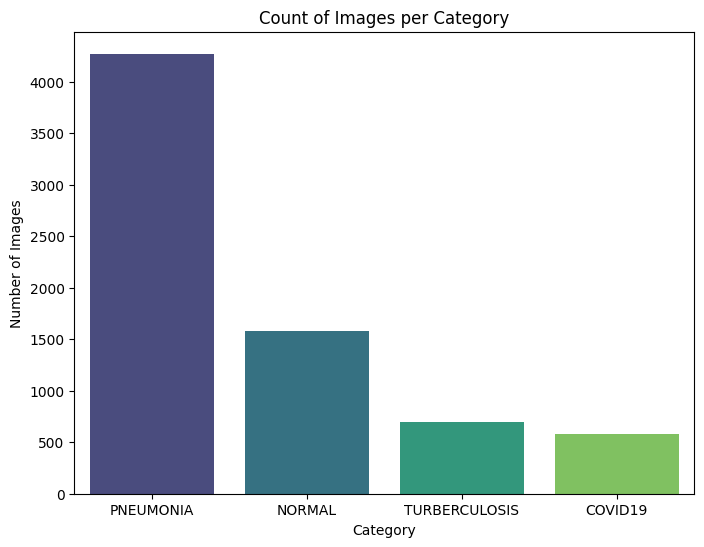

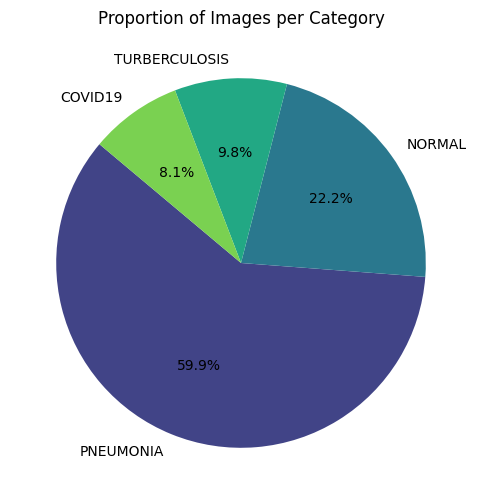

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = df['category'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Count of Images per Category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

plt.figure(figsize=(8, 6))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(category_counts)))
plt.title("Proportion of Images per Category")
plt.show()

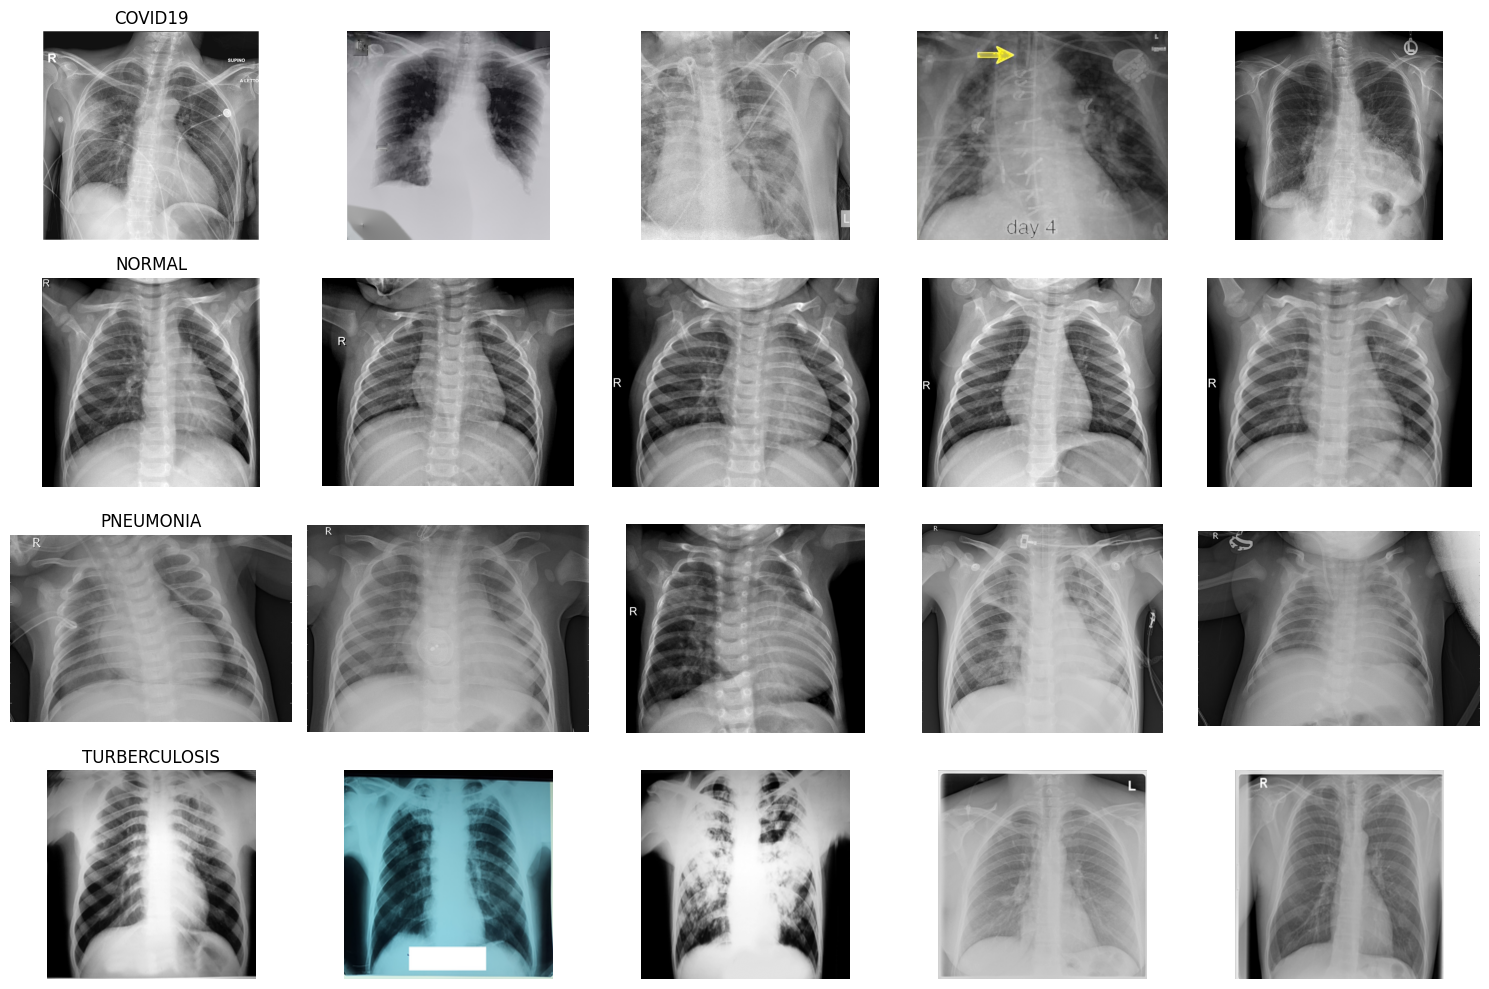

In [ ]:
import random
from PIL import Image

num_images_per_category = 5

plt.figure(figsize=(15, 10))

for i, category in enumerate(df['category'].unique()):

    category_images = df[df['category'] == category]['image_path']

    selected_images = random.sample(list(category_images), num_images_per_category)

    for j, image_path in enumerate(selected_images):

        img = Image.open(image_path)

        plt.subplot(len(df['category'].unique()), num_images_per_category, i * num_images_per_category + j + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(category if j == 0 else "")

plt.tight_layout()
plt.show()

In [ ]:
def encoder_block(inputs, num_filters):

	x = tf.keras.layers.Conv2D(num_filters,
							3,
							padding = 'valid')(inputs)
	x = tf.keras.layers.Activation('relu')(x)

	x = tf.keras.layers.Conv2D(num_filters,
							3,
							padding = 'valid')(x)
	x = tf.keras.layers.Activation('relu')(x)

	x = tf.keras.layers.MaxPool2D(pool_size = (2, 2),
								strides = 2)(x)

	return x

In [ ]:
from tensorflow.keras.layers import Lambda

def decoder_block(inputs, skip_features, num_filters):

    x = tf.keras.layers.Conv2DTranspose(num_filters,
                                        (2, 2),
                                        strides = 2,
                                        padding = 'valid')(inputs)


    x = Lambda(lambda x: tf.image.resize(x, size=(skip_features.shape[1], skip_features.shape[2])))(x)

    x = tf.keras.layers.Concatenate()([x, skip_features])

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [ ]:
import tensorflow as tf

def unet_model(input_shape = (256, 256, 3), num_classes = 2):
	inputs = tf.keras.layers.Input(input_shape)

	s1 = encoder_block(inputs, 64)
	s2 = encoder_block(s1, 128)
	s3 = encoder_block(s2, 256)
	s4 = encoder_block(s3, 512)

	b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(s4)
	b1 = tf.keras.layers.Activation('relu')(b1)
	b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(b1)
	b1 = tf.keras.layers.Activation('relu')(b1)

	s5 = decoder_block(b1, s4, 512)
	s6 = decoder_block(s5, s3, 256)
	s7 = decoder_block(s6, s2, 128)
	s8 = decoder_block(s7, s1, 64)

	outputs = tf.keras.layers.Conv2D(num_classes,
									1,
									padding = 'valid',
									activation = 'sigmoid')(s8)

	model = tf.keras.models.Model(inputs = inputs,
								outputs = outputs,
								name = 'U-Net')
	return model

if __name__ == '__main__':
	model = unet_model(input_shape=(572, 572, 3), num_classes=2)
	model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 572, 572, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 570, 570, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 570, 570, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 568, 568, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 568, 568, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 284, 284, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 282, 282, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 282, 282, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 280, 280, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 280, 280, 128)  │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 140, 140, 128)  │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 138, 138, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 138, 138, 256)  │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 136, 136, 256)  │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 136, 136, 256)  │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 68, 68, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 66, 66, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 66, 66, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,031,810 (118.38 MB)

 Trainable params: 31,031,810 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [ ]:
df

,image_path,category,category_encoded
0,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19,0
1,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19,0
2,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19,0
3,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19,0
4,/content/dataset/Chest X_Ray Dataset/COVID19/C...,COVID19,0
...,...,...,...
7127,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS,3
7128,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS,3
7129,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS,3
7130,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,TURBERCULOSIS,3


In [ ]:
df = df[['image_path', 'category_encoded']]

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])

In [ ]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled

In [ ]:
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    4273
1    4273
2    4273
3    4273
Name: count, dtype: int64


In [ ]:
df_resampled

,image_path,category_encoded
0,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
1,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
2,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
3,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
4,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
...,...,...
17087,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3
17088,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3
17089,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3
17090,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3


In [ ]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the U-Net model (assuming encoder_block and decoder_block are defined)
def unet_model(input_shape=(256, 256, 3), num_classes=2):
    inputs = tf.keras.layers.Input(input_shape)
    
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)
    
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(s4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)
    
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)
    
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='valid', activation='sigmoid')(s8)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

# Function to create folders for each class
def create_folders():
    class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
    for class_name in class_names:
        class_dir = os.path.join('/kaggle/working/', class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

# Function to generate segmentation masks
def generate_segmentation_masks(df, model, img_size=(256, 256)):
    # Define the class names based on your categories
    class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
    
    # Ensure category_encoded is of integer type
    df['category_encoded'] = pd.to_numeric(df['category_encoded'], errors='coerce')
    
    for idx, row in df.iterrows():
        image_path = row['image_path']
        class_label = row['category_encoded']  # This should now be an integer
        
        # Ensure the class label is within the correct range
        if class_label < 0 or class_label >= len(class_names):
            print(f"Warning: Invalid class label {class_label} for image {image_path}. Skipping.")
            continue
        
        # Define the class name based on the label (integer value)
        class_name = class_names[class_label]  # Map class_label to class name
        
        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Predict segmentation mask using the trained model
        pred_mask = model.predict(img_array)
        pred_mask = tf.squeeze(pred_mask, axis=0)  # Remove batch dimension
        
        # If the model has 2 channels (e.g., for binary classification), select one channel or threshold
        if pred_mask.shape[-1] == 2:
            # Choose the channel of interest (e.g., channel for the 'COVID19' class)
            pred_mask = np.argmax(pred_mask, axis=-1)  # Convert to single-channel mask (class prediction)
        
        # If it's a binary mask, ensure it's binary (0 or 1)
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        
        # Add the channel dimension to make it (height, width, 1)
        pred_mask = np.expand_dims(pred_mask, axis=-1)
        
        # Create the directory for the class if it doesn't exist
        output_dir = f'/kaggle/working/{class_name}'
        os.makedirs(output_dir, exist_ok=True)
        
        # Save the predicted mask as an image
        mask_image_path = os.path.join(output_dir, f'{os.path.basename(image_path)}_mask.png')
        tf.keras.preprocessing.image.save_img(mask_image_path, pred_mask)
        
        print(f"Saved mask for {image_path} to {mask_image_path}")

# Now, you can use the model and df_resampled to generate masks
# Example usage:
# Assuming df_resampled is your dataframe
model = unet_model(input_shape=(256, 256, 3), num_classes=2)  # Adjust num_classes for your use case
generate_segmentation_masks(df_resampled, model)


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def unet_model(input_shape=(256, 256, 3), num_classes=2):
    inputs = tf.keras.layers.Input(input_shape)

    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(s4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='valid', activation='sigmoid')(s8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

def create_folders():
    class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
    for class_name in class_names:
        class_dir = os.path.join('/kaggle/working/', class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

def generate_segmentation_masks(df, model, img_size=(256, 256), num_images_per_class=100):

    class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

    df['category_encoded'] = pd.to_numeric(df['category_encoded'], errors='coerce')

    for class_label in range(len(class_names)):
        class_df = df[df['category_encoded'] == class_label].sample(n=num_images_per_class, random_state=42)

        for idx, row in class_df.iterrows():
            image_path = row['image_path']
            class_label = row['category_encoded']

            class_name = class_names[class_label]

            img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = tf.expand_dims(img_array, axis=0)

            pred_mask = model.predict(img_array)
            pred_mask = tf.squeeze(pred_mask, axis=0)

            if pred_mask.shape[-1] == 2:

                pred_mask = np.argmax(pred_mask, axis=-1)

            pred_mask = (pred_mask > 0.5).astype(np.uint8)

            pred_mask = np.expand_dims(pred_mask, axis=-1)

            output_dir = f'/kaggle/working/{class_name}'
            os.makedirs(output_dir, exist_ok=True)

            mask_image_path = os.path.join(output_dir, f'{os.path.basename(image_path)}_mask.png')
            tf.keras.preprocessing.image.save_img(mask_image_path, pred_mask)

            print(f"Saved mask for {image_path} to {mask_image_path}")


model = unet_model(input_shape=(256, 256, 3), num_classes=2)
generate_segmentation_masks(df_resampled, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Saved mask for /content/dataset/Chest X_Ray Dataset/COVID19/COVID19(287).jpg to /kaggle/working/COVID19/COVID19(287).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Saved mask for /content/dataset/Chest X_Ray Dataset/COVID19/COVID19(195).jpg to /kaggle/working/COVID19/COVID19(195).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Saved mask for /content/dataset/Chest X_Ray Dataset/COVID19/COVID19(87).jpg to /kaggle/working/COVID19/COVID19(87).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Saved mask for /content/dataset/Chest X_Ray Dataset/COVID19/COVID19(250).jpg to /kaggle/working/COVID19/COVID19(250).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Saved mask for /content/dataset/Chest X_Ray Dataset/COVID19/COVID19(125).jpg to /kaggle/working/COVID19/COVID19(125).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Saved mask for /content/dataset/Chest X_Ray Dataset/COVID19/COVID19(431).jpg to /kaggle/working/COVID19/COVID19(431).jpg_mask.

In [ ]:
df_resampled

,image_path,category_encoded
0,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
1,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
2,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
3,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
4,/content/dataset/Chest X_Ray Dataset/COVID19/C...,0
...,...,...
17087,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3
17088,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3
17089,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3
17090,/content/dataset/Chest X_Ray Dataset/TURBERCUL...,3


In [ ]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [ ]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [ ]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded']
)

In [ ]:
batch_size = 16
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 13673 validated image filenames belonging to 4 classes.
Found 1709 validated image filenames belonging to 4 classes.
Found 1710 validated image filenames belonging to 4 classes.


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
def unet_classification_model(input_size=(256, 256, 3), num_classes=4):
    inputs = layers.Input(input_size)

    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(bottleneck)

    upconv3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    concat3 = layers.concatenate([upconv3, conv3])
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    upconv2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat2 = layers.concatenate([upconv2, conv2])
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    upconv1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat1 = layers.concatenate([upconv1, conv1])
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    gap = layers.GlobalAveragePooling2D()(conv6)

    output = layers.Dense(num_classes, activation='softmax')(gap)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

model = unet_classification_model(input_size=(256, 256, 3), num_classes=4)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 64)   │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 128)    │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 256)    │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 64, 64, 256)    │        524,544 │ conv2d_45[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 64, 64, 512)    │              0 │ conv2d_transpose_8[0]… │
│ (Concatenate)             │                        │                │ conv2d_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 64, 64, 256)    │      1,179,904 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_9   

 Total params: 7,697,540 (29.36 MB)

 Trainable params: 7,697,540 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_gen_new,
    epochs=3,
    batch_size=16,
    validation_data=valid_gen_new,
    steps_per_epoch=train_gen_new.samples // train_gen_new.batch_size,
    validation_steps=valid_gen_new.samples // valid_gen_new.batch_size,
    verbose=1
)

Epoch 1/3
854/854 ━━━━━━━━━━━━━━━━━━━━ 519s 607ms/step - accuracy: 0.9120 - loss: 0.2321 - val_accuracy: 0.9346 - val_loss: 0.1895
Epoch 2/3
854/854 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.8750 - loss: 0.3998 - val_accuracy: 0.9346 - val_loss: 0.1955
Epoch 3/3
854/854 ━━━━━━━━━━━━━━━━━━━━ 521s 610ms/step - accuracy: 0.9277 - loss: 0.1969 - val_accuracy: 0.9381 - val_loss: 0.1734


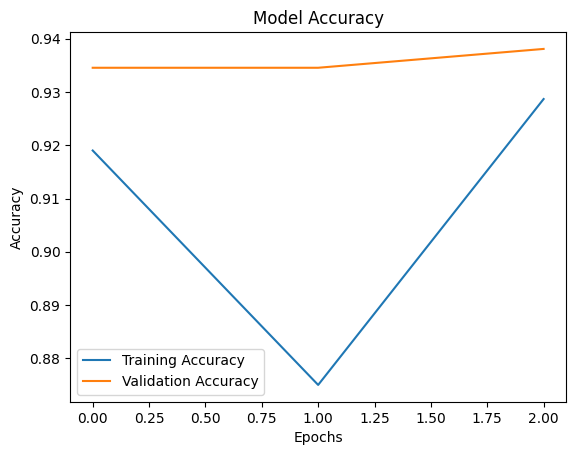

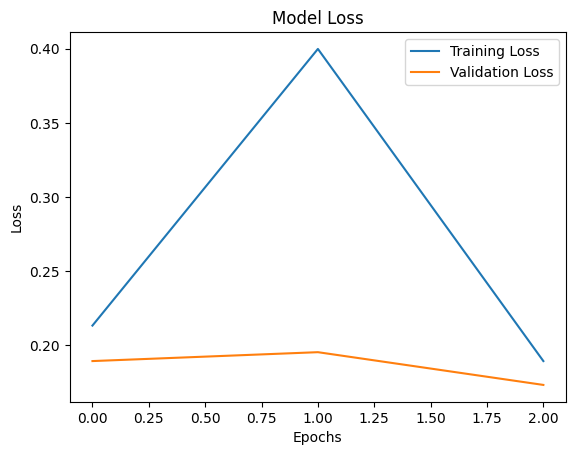

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = model.predict(test_gen_new)
y_pred = np.argmax(y_pred_probs, axis=1)

107/107 ━━━━━━━━━━━━━━━━━━━━ 50s 449ms/step


In [ ]:
y_true = test_gen_new.classes

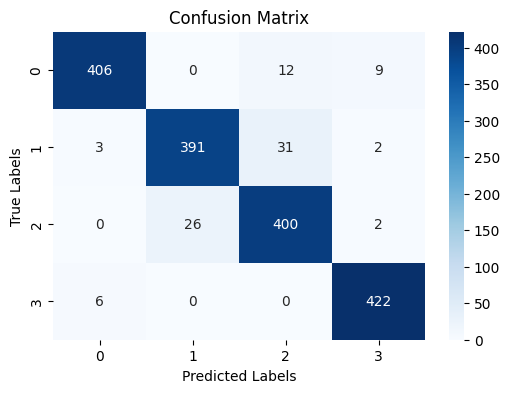

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen_new.class_indices.keys(), yticklabels=test_gen_new.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=test_gen_new.class_indices.keys())
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       427
           1       0.94      0.92      0.93       427
           2       0.90      0.93      0.92       428
           3       0.97      0.99      0.98       428

    accuracy                           0.95      1710
   macro avg       0.95      0.95      0.95      1710
weighted avg       0.95      0.95      0.95      1710



In [ ]:
def attention_gate(x, g, inter_channels):
    """Attention Gate Implementation."""
    theta_x = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    add_xg = layers.Add()([theta_x, phi_g])
    relu_xg = layers.Activation('relu')(add_xg)
    psi = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(relu_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    attention = layers.Multiply()([x, sigmoid_xg])
    return attention

def unet_with_attention(input_size=(256, 256, 3), num_classes=4):
    inputs = layers.Input(input_size)

    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(bottleneck)

    upconv3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    attn3 = attention_gate(conv3, upconv3, inter_channels=128)
    concat3 = layers.concatenate([upconv3, attn3])
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    upconv2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    attn2 = attention_gate(conv2, upconv2, inter_channels=64)
    concat2 = layers.concatenate([upconv2, attn2])
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    upconv1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    attn1 = attention_gate(conv1, upconv1, inter_channels=32)
    concat1 = layers.concatenate([upconv1, attn1])
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    gap = layers.GlobalAveragePooling2D()(conv6)
    output = layers.Dense(num_classes, activation='softmax')(gap)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

model = unet_with_attention(input_size=(256, 256, 3), num_classes=4)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 128, 128, 64)   │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 128)    │              0 │ conv2d_55[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 256)    │              0 │ conv2d_57[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_11       │ (None, 64, 64, 256)    │        524,544 │ conv2d_59[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 128)    │         32,896 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 64, 64, 128)    │         32,896 │ conv2d_transpose_11[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 128)    │              0 │ conv2d_60[0][0],       │
│                           │                        │                │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36        

 Total params: 7,784,231 (29.69 MB)

 Trainable params: 7,784,231 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_gen_new,
    epochs=5,
    batch_size=16,
    validation_data=valid_gen_new,
    steps_per_epoch=train_gen_new.samples // train_gen_new.batch_size,
    validation_steps=valid_gen_new.samples // valid_gen_new.batch_size,
    verbose=1
)

Epoch 1/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 580s 679ms/step - accuracy: 0.8642 - loss: 0.3750 - val_accuracy: 0.8927 - val_loss: 0.2909
Epoch 2/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 1.0000 - loss: 0.1110 - val_accuracy: 0.8880 - val_loss: 0.2967
Epoch 3/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 582s 681ms/step - accuracy: 0.8927 - loss: 0.2972 - val_accuracy: 0.9074 - val_loss: 0.2530
Epoch 4/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 1.0000 - loss: 0.1919 - val_accuracy: 0.9051 - val_loss: 0.2600
Epoch 5/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 622s 717ms/step - accuracy: 0.8938 - loss: 0.2844 - val_accuracy: 0.9092 - val_loss: 0.2422


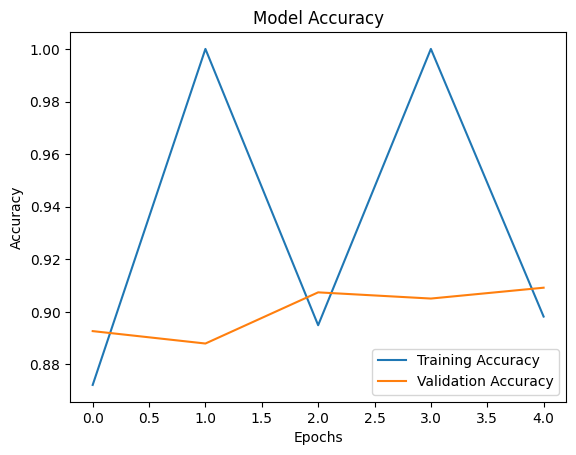

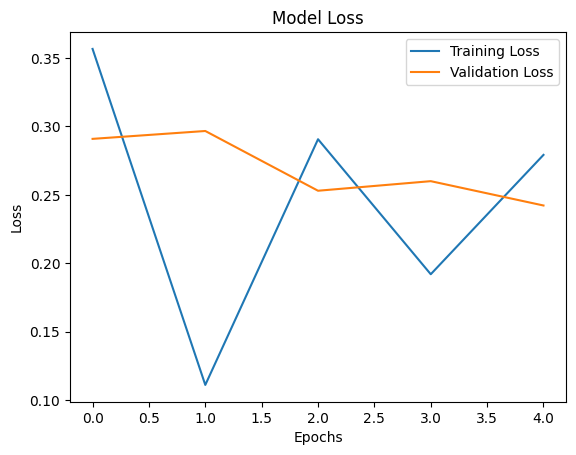

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = model.predict(test_gen_new)
y_pred = np.argmax(y_pred_probs, axis=1)

In [ ]:
y_true = test_gen_new.classes

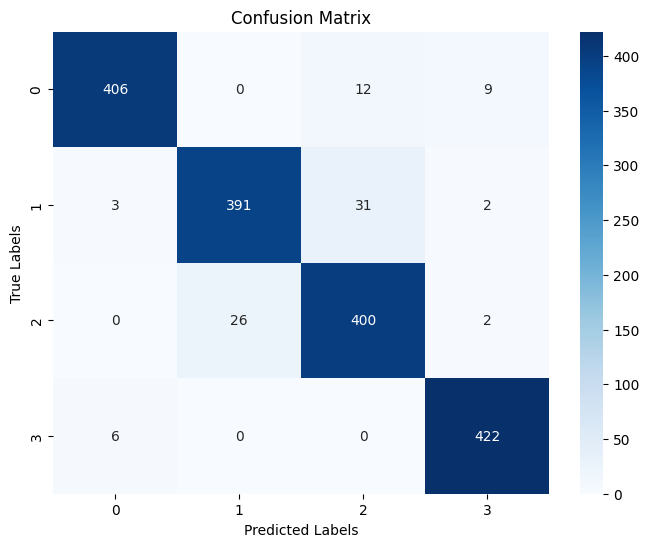

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen_new.class_indices.keys(), yticklabels=test_gen_new.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred, target_names=test_gen_new.class_indices.keys())
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       427
           1       0.94      0.92      0.93       427
           2       0.90      0.93      0.92       428
           3       0.97      0.99      0.98       428

    accuracy                           0.95      1710
   macro avg       0.95      0.95      0.95      1710
weighted avg       0.95      0.95      0.95      1710



In [ ]:
model.save("xray.keras")

In [ ]:
from google.colab import files
files.download("xray.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>